In [7]:
import numpy as np  
import glob as glob
import os

# read in files to a dictionary based on file name results/{LABEL}_r{MUTANTID}_model_md.interactions.log
def read_files(files):
    data = {}
    for file in files:
        #label = os.path.basename(file).split('_')[0]
        #mutantid = file.split('_')[1][1:]
        #data[label + ":"+mutantid] = np.loadtxt(file, skiprows=1)
        label = "_".join(  os.path.basename(file).split("_")[:2] )
        #print(f"parsing {file}")
        try: 
            new_data = np.loadtxt(file, skiprows=1)
        except ValueError as e:
            print(f"Error parsing {file} {e}, skipping)")
            pass
        data[label] = new_data

    return data

results_dir = "output/validation_sequences_9Feb2025"

# read in the files from the results directory
files = glob.glob(os.path.join(results_dir,"*/*/md_implicit/*.interactions.log"))
data = read_files(files)


Error parsing output/validation_sequences_9Feb2025/p06876/p06876_mut8/md_implicit/p06876_mut8_model_md.interactions.log the number of columns changed from 5 to 1 at row 366; use `usecols` to select a subset and avoid this error, skipping)
Error parsing output/validation_sequences_9Feb2025/p06876/p06876_mut17/md_implicit/p06876_mut17_model_md.interactions.log the number of columns changed from 5 to 1 at row 1508; use `usecols` to select a subset and avoid this error, skipping)
Error parsing output/validation_sequences_9Feb2025/p06876/p06876_mut36/md_implicit/p06876_mut36_model_md.interactions.log the number of columns changed from 5 to 1 at row 464; use `usecols` to select a subset and avoid this error, skipping)


In [8]:
# get reference data
import pandas as pd
reference_csv_file = "raw_inputs/validation_sequences_9Feb2025.csv"
reference_df = pd.read_csv(reference_csv_file,keep_default_na=False)
# uniprot_id.lower(), wild_G0
reference_energies_dict = {}
reference_wild_G0_dict = {}
reference_nuc_length_dict = {}
name_count_dict = {}
reference_nuc_type_dict = {}
seq_index = {}
for index, row in reference_df.iterrows():
    name = row['uniprot_id'].lower()
    if name not in name_count_dict:
        name_count_dict[name] = 1
        seq_index[name] = len(name_count_dict)
    else:
        name_count_dict[name] += 1

    mutid = name_count_dict[name]
#(seq_index[name], row['ddG'])
    sequence_length = len(row['mutated_nucleotide_strand1'])
    reference_energies_dict[name+"_mut"+str(mutid)] = row['ddG']
    reference_nuc_length_dict[name+"_mut"+str(mutid)] = sequence_length
    reference_nuc_type_dict[name+"_mut"+str(mutid)] = row['nucleotide_sequence_type']
    reference_wild_G0_dict[name+"_mut"+str(mutid)] = row['wild_G0']

print(reference_energies_dict)

{'p32081_mut1': '0.48', 'p32081_mut2': '0.02', 'p32081_mut3': '0.34', 'p32081_mut4': '0.34', 'p32081_mut5': '0.98', 'p32081_mut6': '1.28', 'p32081_mut7': '0.42', 'p32081_mut8': '0.42', 'p32081_mut9': '0.72', 'q57468_mut1': '-0.43', 'q57468_mut2': '0', 'q57468_mut3': '0', 'q57468_mut4': '1.28', 'q57468_mut5': '0', 'q57468_mut6': '0.85', 'q57468_mut7': '0.85', 'q57468_mut8': '1.28', 'q57468_mut9': '0.85', 'q57468_mut10': '1.28', 'q57468_mut11': '1.28', 'q57468_mut12': '1.28', 'q57468_mut13': '1.28', 'q57468_mut14': '1.28', 'q57468_mut15': '1.28', 'q57468_mut16': '1.28', 'q57468_mut17': '1.28', 'q57468_mut18': '-0.43', 'q57468_mut19': '0', 'p16117_mut1': '-6.17', 'p16117_mut2': '-5.76', 'p16117_mut3': '-5.76', 'p03049_mut1': '3.94', 'p03049_mut2': '2.73', 'p03049_mut3': '2.09', 'p03049_mut4': '3.03', 'p03049_mut5': '2.48', 'p03049_mut6': '3.4', 'p03049_mut7': '3.45', 'p04891_mut1': '-9.9', 'p04891_mut2': '-7.4', 'p04891_mut3': '-7.4', 'p04891_mut4': '1.14', 'p03045_mut1': '0.33', 'p03045_

In [72]:
# loop over keys in data containing 'mut' and check if same mutant has a 'ref' entry
# if so, calculate the difference between the two

# create a pandas data frame with the following columns: uniprot_id, mut_id, ddG, ddG_pred
results_df = pd.DataFrame(columns=['uniprot_id','mut_id','nuc_type','ddG','ddG_measured','frac_ddG_measured' 'nuc_length', 'frac_ddG', 'mut_dG_measured','mut_avg_dG'])

for key in data.keys():
    if key.find('mut')>0:
        uniprot_id = key.split('_')[0]
        ref_key = "_".join([uniprot_id,'ref'])

        if ref_key in data:
            mutant_data = data[key]
            ref_data = data[ref_key]
            mut_avg_energy = np.mean(mutant_data[len(mutant_data)//2:,-1])
            ref_avg_energy = np.mean(ref_data[len(ref_data)//2:,-1])
            ddG = mut_avg_energy - ref_avg_energy
            ddG_kcal = ddG/4.184
            G0 = float(reference_wild_G0_dict[key])
            mut_id = int(key.split('_')[1].replace("mut",""))
            ddG_measured = reference_energies_dict[key]
            
            if G0 != 0 and len(ddG_measured)>0:
                frac_ddG_measured = float(ddG_measured)/G0
                mut_dG_measured = float(ddG_measured) + G0
            else:
                frac_ddG_measured = np.nan

            nuc_length = reference_nuc_length_dict[key]
            nuc_type = reference_nuc_type_dict[key]

            frac_ddG = ddG_kcal/ref_avg_energy


            if len(ddG_measured)>0:
                results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'frac_ddG_measured':frac_ddG_measured, 'nuc_length':nuc_length, 'frac_ddG': frac_ddG, 'mut_dG_measured':mut_dG_measured,  'mut_avg_dG':mut_avg_energy },ignore_index=True)
            else:
                print(f"no ddG for {key}")
    else:
        pass

/tmp/ipykernel_910422/2657720917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'frac_ddG_measured':frac_ddG_measured, 'nuc_length':nuc_length, 'frac_ddG': frac_ddG, 'mut_dG_measured':mut_dG_measured,  'mut_avg_dG':mut_avg_energy },ignore_index=True)
/tmp/ipykernel_910422/2657720917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'frac_ddG_measured':frac_ddG_measured, 'nuc_length':nuc_length, 'frac_ddG': frac_ddG, 'mut_dG_measured':mut_dG_measured,  'mut_avg_dG':mut_avg_energy },ignore_index=True)
/tmp/ipykernel_91042

no ddG for p03332_mut2
no ddG for p03332_mut1
no ddG for p03332_mut4
no ddG for p03332_mut3
no ddG for p03332_mut5


/tmp/ipykernel_910422/2657720917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'frac_ddG_measured':frac_ddG_measured, 'nuc_length':nuc_length, 'frac_ddG': frac_ddG, 'mut_dG_measured':mut_dG_measured,  'mut_avg_dG':mut_avg_energy },ignore_index=True)
/tmp/ipykernel_910422/2657720917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'frac_ddG_measured':frac_ddG_measured, 'nuc_length':nuc_length, 'frac_ddG': frac_ddG, 'mut_dG_measured':mut_dG_measured,  'mut_avg_dG':mut_avg_energy },ignore_index=True)
/tmp/ipykernel_91042

In [28]:
results_df.head()
# get the min and max of the column ddG_measured
min_ddG = results_df['ddG_measured'].min()
max_ddG = results_df['ddG_measured'].max()
print(min_ddG, max_ddG)
print(len(results_df))
print(reference_nuc_type_dict)

-9.9 7.69
479
{'p32081_mut1': 'RNA', 'p32081_mut2': 'RNA', 'p32081_mut3': 'RNA', 'p32081_mut4': 'RNA', 'p32081_mut5': 'RNA', 'p32081_mut6': 'RNA', 'p32081_mut7': 'RNA', 'p32081_mut8': 'RNA', 'p32081_mut9': 'RNA', 'q57468_mut1': 'DNA', 'q57468_mut2': 'DNA', 'q57468_mut3': 'DNA', 'q57468_mut4': 'DNA', 'q57468_mut5': 'DNA', 'q57468_mut6': 'DNA', 'q57468_mut7': 'DNA', 'q57468_mut8': 'DNA', 'q57468_mut9': 'DNA', 'q57468_mut10': 'DNA', 'q57468_mut11': 'DNA', 'q57468_mut12': 'DNA', 'q57468_mut13': 'DNA', 'q57468_mut14': 'DNA', 'q57468_mut15': 'DNA', 'q57468_mut16': 'DNA', 'q57468_mut17': 'DNA', 'q57468_mut18': 'DNA', 'q57468_mut19': 'DNA', 'p16117_mut1': 'DNA', 'p16117_mut2': 'DNA', 'p16117_mut3': 'DNA', 'p03049_mut1': 'DNA', 'p03049_mut2': 'DNA', 'p03049_mut3': 'DNA', 'p03049_mut4': 'DNA', 'p03049_mut5': 'DNA', 'p03049_mut6': 'DNA', 'p03049_mut7': 'DNA', 'p04891_mut1': 'RNA', 'p04891_mut2': 'RNA', 'p04891_mut3': 'RNA', 'p04891_mut4': 'RNA', 'p03045_mut1': 'RNA', 'p03045_mut2': 'RNA', 'p03045

Correlation coefficient: 0.18026658233071882


Text(0.7, 0.9, '$r^2 = 0.03$')

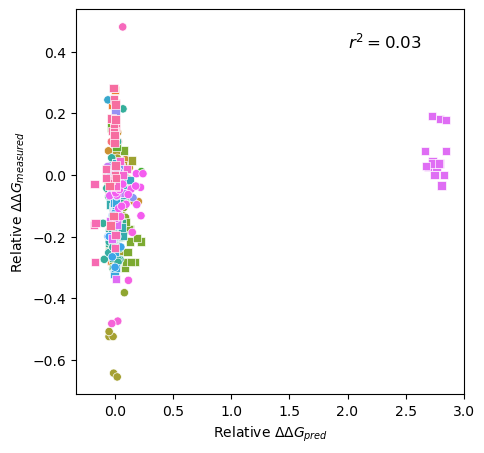

In [30]:
# use seaborn to make a scatter plot of ddG_per vs ddG_measured
import seaborn as sns
import matplotlib.pyplot as plt


#get pearson correlation coefficient between these two columns
from scipy.stats import pearsonr
frac_ddG = results_df['frac_ddG']
frac_ddG_measured = results_df['frac_ddG_measured']
# remove nans from frac_ddG_measured in both
frac_ddG = frac_ddG[~np.isnan(frac_ddG_measured)]
frac_ddG_measured = frac_ddG_measured[~np.isnan(frac_ddG_measured)]
corr, _ = pearsonr(frac_ddG,frac_ddG_measured)
print(f"Correlation coefficient: {corr}")

plt.figure(figsize=(5,5))
# color by uniprot_id
# use squares if nuc_type is 'DNA' and circles if nuc_type is 'RNA'
sns.scatterplot(data=results_df,x='frac_ddG',y='frac_ddG_measured',hue='uniprot_id',style='nuc_type',markers={'DNA':'s','RNA':'o'})

#set x range to -10,10
#plt.xlim(-10,10)
#turn of legend
plt.legend().remove()
plt.ylabel("Relative $\Delta \Delta G_{measured}$")
plt.xlabel("Relative $\Delta \Delta G_{pred}$")
#add r^2 to the plot, with larger font size and in the top right corner
plt.text(0.7,0.9,f"$r^2 = {corr**2:.2f}$",transform=plt.gca().transAxes,fontsize=12)

#plt.xlabel("$\Delta \Delta G_{pred}$ per Nuc length (kcal/mol)")
#plt.ylabel("$\Delta \Delta G_{measured}$ (kcal/mol) (?)")
#plt.yticks(np.arange(-10,10,2))

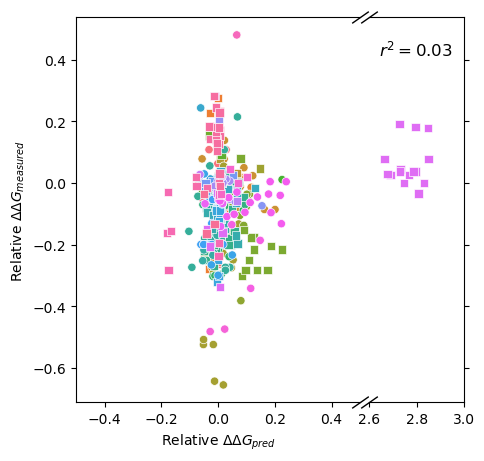

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, width_ratios=[3, 1], figsize=(5,5))
fig.subplots_adjust(wspace=0.05)  # adjust space between Axes
sns.scatterplot(data=results_df, x='frac_ddG', y='frac_ddG_measured', hue='uniprot_id', style='nuc_type', markers={'DNA':'s','RNA':'o'}, ax=ax1)
sns.scatterplot(data=results_df, x='frac_ddG', y='frac_ddG_measured', hue='uniprot_id', style='nuc_type', markers={'DNA':'s','RNA':'o'}, ax=ax2)
ax1.legend().remove()
ax2.legend().remove()
ax1.set_xlim(-0.5,0.5)
ax2.set_xlim(2.6,3)

# hide the spines between ax and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
#ax1.yaxis.tick_top()
ax1.tick_params(labelright=False)  # don't put tick labels at the top
ax2.yaxis.tick_right()
# 
ax1.set_ylabel("Relative $\Delta \Delta G_{measured}$")
ax1.set_xlabel("Relative $\Delta \Delta G_{pred}$")
ax2.set_xlabel("")


d = .7  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)

plt.text(0.1,0.9,f"$r^2 = {corr**2:.2f}$",transform=plt.gca().transAxes,fontsize=12)
plt.savefig(os.path.join(results_dir,"relative_ddG_pred_vs_measured.png"),dpi=300)
#plt.tight_layout()

Correlation coefficient: 0.35075833918857724


Text(0, 0.5, '$\\Delta G_{measured}$ (kcal/mol)')

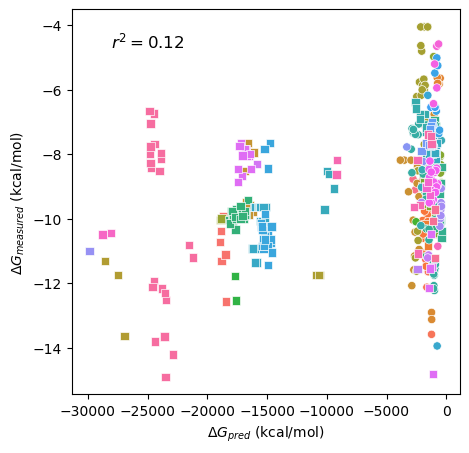

In [81]:
mut_dG_measured = results_df['mut_dG_measured']
mut_avg_dG = results_df['mut_avg_dG']

#divide by nuc length
mut_avg_dG_perlength = mut_avg_dG/results_df['nuc_length']

# remove nans from frac_ddG_measured in both
mut_dG_measured = mut_dG_measured[~np.isnan(mut_dG_measured)]
mut_avg_dG = mut_avg_dG[~np.isnan(mut_dG_measured)]
corr, _ = pearsonr(mut_avg_dG,mut_dG_measured)
print(f"Correlation coefficient: {corr}")

plt.figure(figsize=(5,5))
# color by uniprot_id
# use squares if nuc_type is 'DNA' and circles if nuc_type is 'RNA'
sns.scatterplot(data=results_df,x='mut_avg_dG',y='mut_dG_measured',hue='uniprot_id',style='nuc_type',markers={'DNA':'s','RNA':'o'})

#set x range to -10,10
#plt.xlim(-10,10)
#turn of legend
plt.legend().remove()



#add r^2 to the plot, with larger font size and in the top right corner
plt.text(0.1,0.9,f"$r^2 = {corr**2:.2f}$",transform=plt.gca().transAxes,fontsize=12)

plt.xlabel("$\Delta G_{pred}$ (kcal/mol)")
plt.ylabel("$\Delta G_{measured}$ (kcal/mol)")
#plt.yticks(np.arange(-10,10,2))





In [ ]:
sns.scatterplot(data=results_df,x='mut_avg_dG',y='mut_dG_measured',hue='uniprot_id',style='nuc_type',markers={'DNA':'s','RNA':'o'})
